## Toy Model 1: 2 spatial modes with different oscillating frequencies

### Created by Yuying Liu, 09/23/2019

$$\Phi(x, t) = u(x)cos(\omega_0 t) + v(x)cos(\omega_1 t + \frac{\pi}{4})$$

In [1]:
# imports
import os
import sys
import torch
import pickle
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import time

module_path = os.path.abspath(os.path.join('../src/'))
if module_path not in sys.path:
    sys.path.append(module_path)
    
    
import torch_cae_multilevel_V4 as net
import ResNet as tnet
import utils

## MrCAE

Below is the progressive training framework. 
One could have flexible control over each training step: low-level models are cheap to obtain, and higher level models are built based on them -- one can always revert back to the previous level and adjust the parameters to re-train the model if it is not satisfying. 

C:\Users\16kat\OneDrive - acornonsite.com\Time_Space_multiscale\src\utils.py:171: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data = torch.tensor(data)


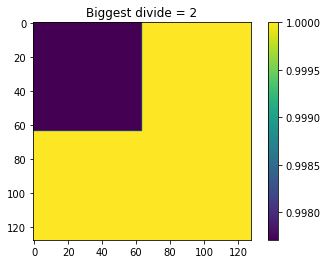

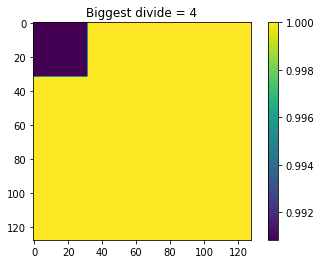

KeyboardInterrupt: 

In [2]:
# init model & load data
data_path = '../data/toy2'
model_path = '../model/toy2'
result_path = '../result/toy2/'

full_data_path = os.path.join(data_path, 'data.npy')
data = np.load(full_data_path)


#predict 2x2 and graph
current_size = 2
next_size = current_size * 2
resolved = False
current_data = utils.grow(utils.data_of_size(data,current_size))
next_data = utils.grow(utils.data_of_size(data,next_size))

plt.imshow(current_data[0])
plt.title("Biggest divide = "+str(current_size))
plt.colorbar()
plt.show()
resolved, loss, unresolved = utils.MSE(current_data, next_data, current_size)
while resolved == False:

    current_data = utils.make_next_layer(next_data, current_data, unresolved)
    current_size *=2
    next_size = current_size * 2
    next_data = utils.grow(utils.data_of_size(data,next_size))
    plt.imshow(current_data[0])
    plt.title("Biggest divide = "+str(current_size))
    plt.colorbar()
    plt.show()
    
    resolved, loss, unresolved = utils.MSE(current_data, next_data, current_size)




# This is where some time stuff will start eventually 

In [ ]:
#getting time inputs
# t = np.linspace(0, 8*np.pi, 500)
k = 0                         # model index: should be in {0, 2, ..., 10}
dt = 1#t[1] - t[0]              # time unit: 0.0005 for Lorenz and 0.01 for others
system = 'toy1_longer'
noise = 0.0                   # noise percentage: 0.00, 0.01 or 0.02

lr = 1e-3                     # learning rate
max_epochs = 10000            # the maximum training epoch 
batch_size = 320              # training batch size
min_k = 7
max_k = 8

print(val_encoded.shape)
_,n_steps, total_dim= val_encoded.shape
n_steps = n_steps - 1
# total_dim = n_per_dim **2
print("total_dim = ", total_dim)
arch = [total_dim, 128, 128, 128, total_dim] 

# global const
n_forward = 5
step_size = 2**k

criterion = torch.nn.MSELoss(reduction='none')
# print(dt)
# dataset = tnet.DataSet(train_encoded, val_encoded, test_encoded, dt, step_size, n_forward)

In [ ]:
#do time training 
time_models = list()
step_sizes = list()
for k in range(min_k, max_k):
    print("k = ", k)
    step_size = 2**k
    step_sizes.append(step_size)
    dataset = tnet.DataSet(train_encoded, val_encoded, test_encoded, dt, step_size, n_forward)#tnet.DataSet(train_data, val_data, test_data, dt, step_size, n_forward)
#     print(dataset.train_x.shape)
    model_name = 'model_D{}_noise{}_0.pt'.format(step_size, noise)
    model_path_this = os.path.join(model_path, model_name)

    # create/load model object
    try:
        device = 'cuda' if torch.cuda.is_available() else 'cpu'
        model_time = torch.load(model_path_this, map_location=device)
        model_time.device = device
    except:
        print('create model {} ...'.format(model_name))
        print('dt = ', dt)
        model_time = tnet.ResNet(arch=arch, dt=dt, step_size=step_size)

    # training
    model_time.train_net(dataset, max_epoch=max_epochs, batch_size=batch_size, lr=lr,
                    model_path=os.path.join(model_path, model_name))
    
# load models
# for step_size in step_sizes:
    print('load model_D{}.pt'.format(step_size))
    time_models.append(torch.load(model_path_this, map_location='cpu'))
    
# fix model consistencies trained on gpus (optional)
for model in time_models:
    model.device = 'cpu'
    model._modules['increment']._modules['activation'] = torch.nn.ReLU()

In [ ]:
val_encoded.shape

In [ ]:
# # uniscale time-stepping with NN
preds_mse = list()
times = list()

for model in tqdm(models):
    start = time.time()
    print(val_encoded.shape)
    y_preds = model.uni_scale_forecast(torch.tensor(val_encoded[:, 0, :]).float(), n_steps=n_steps)
    print("y_preds.shape =", y_preds.shape)
    end = time.time()
    times.append(end - start)
    print('criterion(torch.tensor(val_encoded[:, 1:, :]).float(), y_preds) shape =', criterion(torch.tensor(val_encoded[:, 1:, :]).float(), y_preds).mean(-1).shape )
    preds_mse.append(criterion(torch.tensor(val_encoded[:, 1:, :]).float(), y_preds).mean(-1))
    print(len(preds_mse))
    
# visualize forecasting error at each time step    
fig = plt.figure(figsize=(20, 8))
colors=iter(plt.cm.rainbow(np.linspace(0, 1, max_k-min_k)))
print(colors)
for k in range(max_k-min_k):
    err = preds_mse[k]
    print('err.shape = ', err.shape)
    mean = err[0].detach().numpy()
    rgb = next(colors)
    print(mean.shape)
#     print(len(t))
#     print(t)
    plt.semilogy(mean, linestyle='-', color=rgb, linewidth=3.0, label='$\Delta\ t$={}dt'.format(step_sizes[k]))
plt.legend(fontsize=20, loc='upper right')
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)

plt.ylim([1e-5, 10])
# plt.xlim([0, len(t)])
    

In [ ]:
fig = plt.figure(figsize=(20, 8))
colors=iter(plt.cm.rainbow(np.linspace(0, 1, max_k-min_k)))
print(colors)
for k in range(max_k-min_k):
    err = preds_mse[k]
    mean = err.mean(0).detach().numpy()
#     print(np.mean(mean[::step_every]))
    rgb = next(colors)
    step_every = step_sizes[k]
    t = range(len(mean))
    plt.semilogy(t[::step_every], mean[::step_every], linestyle='-', color=rgb, linewidth=3.0, label='$\Delta\ t$={}dt'.format(step_sizes[k]))
plt.legend(fontsize=20, loc='upper right')
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)

plt.ylim([1e-5, 10])

In [ ]:
#need to predict encoded dta in time and then decode

print(n_steps)
train_preds_time = model.uni_scale_forecast(torch.tensor(train_encoded[:, 0, :]).float(), n_steps=len(train_encoded[0])-1)
val_preds_time = model.uni_scale_forecast(torch.tensor(val_encoded[:, 0, :]).float(), n_steps=n_steps)
test_preds_time = model.uni_scale_forecast(torch.tensor(test_encoded[:, 0, :]).float(), n_steps=len(test_encoded[0])-1)
print(criterion(torch.tensor(train_encoded[:, 1:, :]).float(), train_preds_time).mean(-1).mean())
print(criterion(torch.tensor(val_encoded[:, 1:, :]).float(), val_preds_time).mean(-1).mean())
print(criterion(torch.tensor(test_encoded[:, 1:, :]).float(), test_preds_time).mean(-1).mean())
# train_encoded

#decode
print(train_preds_time.reshape((3499,3,3)).shape)
to_decode_train = torch.tensor(train_preds_time.reshape((3499,3,3))).unsqueeze(1).float()
train_decoded = model_space.decode(to_decode_train, model_space.cur_level)#.reshape((1, len(train_data), len(encoded[0,0])**2))
print(train_decoded.shape)

print(val_preds_time.shape)
to_decode_val = torch.tensor(val_preds_time.reshape((999,3,3))).unsqueeze(1).float()
val_decoded = model_space.decode(to_decode_val, model_space.cur_level)#.reshape((1, len(train_data), len(encoded[0,0])**2))

print(test_preds_time.shape)
to_decode_test = torch.tensor(test_preds_time.reshape((len(test_preds_time[0]),3,3)).unsqueeze(1).float())
test_decoded = model_space.decode(to_decode_test, model_space.cur_level)#.reshape((1, len(train_data), len(encoded[0,0])**2))
print(test_decoded.shape)

In [ ]:
train_preds_time.shape
plt.imshow(train_preds_time[0,500].reshape(3,3))
plt.colorbar()

In [ ]:
print(train_decoded.shape)
plt.imshow(train_decoded[499,0].detach().numpy())
plt.colorbar()
plt.show()
print(train_data.shape)
plt.imshow(train_data[21,0].detach().numpy())
plt.colorbar()
plt.show()

mse =criterion(torch.tensor(train_decoded[:]).float(), train_data[:-1,].float()).mean( axis=(1, 2,3))
print(mse.shape)
plt.semilogy(mse)

In [ ]:

print(test_preds_time.shape)
mse =criterion(torch.tensor(val_decoded[:]).float(), val_data[:-1,].float()).mean( axis=(1,2,3))
print(mse.shape)
plt.semilogy(mse)
plt.title("val error of decoded")
plt.show()

print(test_preds_time.shape)
mse =criterion(torch.tensor(test_decoded[:]).float(), test_data[:-1,].float()).mean( axis=(1,2,3))
print(mse.shape)
plt.semilogy(mse)
plt.title("test error of decoded")

In [ ]:
utils.animate(test_decoded.detach().numpy(), os.path.join(result_path, 'decoded_test_7x7.gif'))

In [ ]:
# torch.tensor(train_decoded[:]).float(), train_data[:-1,].float())
print(train_decoded.shape)
tol = 0.1
fully_resolved, loss, resolved_map = net.check_pixel_level_loss(train_decoded[:499].float(), train_data[1:500,].float(), tol=tol, device = 'cpu')

In [ ]:
print(loss.shape)
plt.imshow(loss.detach().numpy())
plt.colorbar()
plt.show()

plt.imshow(resolved_map.detach().numpy())
plt.colorbar()
plt.show()